In [1]:
import itertools
import numpy as np
from scipy import stats, optimize
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import rcParams
import matplotlib.lines as mlines

In [2]:
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 4}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 379.417 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,0.75*fig_height]
rcParams.update({'figure.figsize': fig_size})

In [3]:
n = 3

TPRs = [0.748,0.681,0.687]
TNRs = [0.997,0.99,1.0]

TPRCIs = [(0.676,0.808),(0.472,0.836),(0.48,0.838)]
TNRCIs = [(0.996,0.998),(0.985,0.993),(0.98,1.0)]

permutations = list(itertools.product([0, 1], repeat=n))

output_functions = list(itertools.product([0, 1], repeat=2**n))

In [4]:
output_functions

[(0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 1, 0, 1),
 (0, 0, 0, 0, 0, 1, 1, 0),
 (0, 0, 0, 0, 0, 1, 1, 1),
 (0, 0, 0, 0, 1, 0, 0, 0),
 (0, 0, 0, 0, 1, 0, 0, 1),
 (0, 0, 0, 0, 1, 0, 1, 0),
 (0, 0, 0, 0, 1, 0, 1, 1),
 (0, 0, 0, 0, 1, 1, 0, 0),
 (0, 0, 0, 0, 1, 1, 0, 1),
 (0, 0, 0, 0, 1, 1, 1, 0),
 (0, 0, 0, 0, 1, 1, 1, 1),
 (0, 0, 0, 1, 0, 0, 0, 0),
 (0, 0, 0, 1, 0, 0, 0, 1),
 (0, 0, 0, 1, 0, 0, 1, 0),
 (0, 0, 0, 1, 0, 0, 1, 1),
 (0, 0, 0, 1, 0, 1, 0, 0),
 (0, 0, 0, 1, 0, 1, 0, 1),
 (0, 0, 0, 1, 0, 1, 1, 0),
 (0, 0, 0, 1, 0, 1, 1, 1),
 (0, 0, 0, 1, 1, 0, 0, 0),
 (0, 0, 0, 1, 1, 0, 0, 1),
 (0, 0, 0, 1, 1, 0, 1, 0),
 (0, 0, 0, 1, 1, 0, 1, 1),
 (0, 0, 0, 1, 1, 1, 0, 0),
 (0, 0, 0, 1, 1, 1, 0, 1),
 (0, 0, 0, 1, 1, 1, 1, 0),
 (0, 0, 0, 1, 1, 1, 1, 1),
 (0, 0, 1, 0, 0, 0, 0, 0),
 (0, 0, 1, 0, 0, 0, 0, 1),
 (0, 0, 1, 0, 0, 0, 1, 0),
 (0, 0, 1, 0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0, 1, 0, 0),
 

In [5]:
def beta_parameters(x1, 
                    p1,
                    x2,
                    p2, 
                    x3 = -1, 
                    p3 = -1):
     
    """ 
        Find parameters for a beta random variable X 
        so that P(X > x1) = p1 and P(X > x2) = p2.
    """
    # This function is adapted from:
    # https://stackoverflow.com/questions/53242101/python-equivelent-of-r-betaexpert-function
    # https://www.codeproject.com/Articles/56371/Finding-Probability-Distribution-Parameters-from-P
                
    def square(x): 
        return x*x

    def objective(v):
        (a, b) = v
        temp  = square( stats.beta.cdf(x1, a, b) - p1 )
        temp += square( stats.beta.cdf(x2, a, b) - p2 )
        if p3 != -1:
            temp += square( stats.beta.cdf(x3, a, b) - p3 )
        return temp
    
    # arbitrary initial guess of (3, 3) for parameters
    xopt = optimize.fmin(objective, (3, 3))
    return (xopt[0], xopt[1])

In [6]:
N_samples = 1000000

TPR_samples_arr = []
TNR_samples_arr = []

for i in range(len(TPRs)):
    alpha, beta = beta_parameters(TPRCIs[i][0], 0.025, \
                                  TPRs[i] , 0.5, \
                                  TPRCIs[i][1], 0.975)

    sen = np.random.beta(alpha, beta, N_samples)
    
    TPR_samples_arr.append(sen)
    
    alpha, beta = beta_parameters(TNRCIs[i][0], 0.025, \
                                  TNRs[i] , 0.5, \
                                  TNRCIs[i][1], 0.975)

    spec = np.random.beta(alpha, beta, N_samples)
    
    TNR_samples_arr.append(spec)

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 0.000269
         Iterations: 111
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 0.000325
         Iterations: 101
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 0.250625
         Iterations: 61
         Function evaluations: 128


In [7]:
TPR_arr = []
TNR_arr = []

for output_func in output_functions:
    TPR_combined = []
    TNR_combined = []
    for perm, output_value in zip(permutations, output_func):
        
        if output_value:
            TPR_combined.append(np.prod([ TPRs[i] if perm[i] else 1-TPRs[i] for i in range(len(perm))]))
        else:
            TNR_combined.append(np.prod([ 1-TNRs[i] if perm[i] else TNRs[i] for i in range(len(perm))]))
                    
        print(perm + (output_value,))
    
    TPR_arr.append(sum(TPR_combined))
    TNR_arr.append(sum(TNR_combined))

    print(TPR_arr[-1])
    print(1-TNR_arr[-1])

    print("\n")

(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 0)
(1, 1, 0, 0)
(1, 1, 1, 0)
0
0.0


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 0)
(1, 1, 0, 0)
(1, 1, 1, 1)
0.34994955600000005
0.0


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
0.15943844399999998
2.999999999997449e-05


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 0)
(1, 1, 0, 1)
(1, 1, 1, 1)
0.5093880000000001
2.999999999997449e-05


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 1)
(1, 1, 0, 0)
(1, 1, 1, 0)
0.16392644399999998
0.0


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 1)
(1, 1, 0, 0)
(1, 1, 1, 1)
0.513876
0.0


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 1)
(1, 1, 0, 1)
(1, 1, 1, 0)
0.32336488799999996
2.999999999997449e-05


(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(

In [8]:
(0, 1, 0, 1, 0, 1, 1, 1)

(0, 1, 0, 1, 0, 1, 1, 1)

In [9]:
TPR_arr = np.array(TPR_arr)
TNR_arr = np.array(TNR_arr)

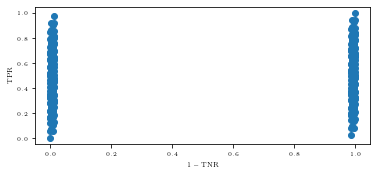

In [10]:
plt.figure()
plt.plot(1-TNR_arr, TPR_arr, 'o')
plt.xlabel(r"$1-\mathrm{TNR}$")
plt.ylabel(r"$\mathrm{TPR}$")
plt.tight_layout()
plt.show()

In [11]:
points = np.c_[1-TNR_arr,TPR_arr]

In [12]:
hull = ConvexHull(points)

In [13]:
def roc_confidence_intervals(roc_simplex):
    roc_indices = sorted(list(set(np.array(roc_simplex).flatten())))
    
    TPR_samples_aggr_arr = []
    TNR_samples_aggr_arr = []

    for i in range(len(roc_indices)):
        output_func = output_functions[roc_indices[i]]
        print(output_func)
        TPR_arr_ = []
        TNR_arr_ = []

        for j in range(N_samples):
            TPR_combined = []
            TNR_combined = []
            for perm, output_value in zip(permutations, output_func):

                if output_value:
                    TPR_combined.append(np.prod([ TPR_samples_arr[k][j] if perm[k] else 1-TPR_samples_arr[k][j] \
                                                  for k in range(len(perm))]))
                else:
                    TNR_combined.append(np.prod([ 1-TNR_samples_arr[k][j] if perm[k] else TNR_samples_arr[k][j] \
                                                  for k in range(len(perm))]))

            TPR_arr_.append(sum(TPR_combined))
            TNR_arr_.append(sum(TNR_combined))

        TPR_samples_aggr_arr.append(np.array(TPR_arr_))
        TNR_samples_aggr_arr.append(np.array(TNR_arr_))
    
    return TPR_samples_aggr_arr, TNR_samples_aggr_arr

[0.01297 1.     ] [0.97483856 1.        ]
[0. 0.] [0.687 0.   ]
[0.e+00 3.e-05] [0.687      0.84643844]
[0.003   0.01297] [0.921124   0.97483856]
[3.e-03 3.e-05] [0.921124   0.84643844]
(0, 0, 0, 0, 0, 0, 0, 0)
(0, 1, 0, 1, 0, 1, 0, 1)
(0, 1, 0, 1, 0, 1, 1, 1)
(0, 1, 0, 1, 1, 1, 1, 1)
(0, 1, 1, 1, 1, 1, 1, 1)
(1, 1, 1, 1, 1, 1, 1, 1)


/home/lucasb/anaconda3/envs/epidemics/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


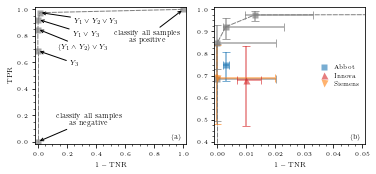

In [23]:
mosaic = """
    AB
    """
fig = plt.figure(constrained_layout=True)
ax = fig.subplot_mosaic(mosaic)
fig.patch.set_facecolor('white')

text = ax["A"].text(0.9*1.04-0.02,0.04*1.04-0.02,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

text = ax["B"].text(0.9*0.052-0.001,0.04*0.624+0.388,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

roc_simplex = []

for simplex in hull.simplices:
    if (points[simplex, 1][0] >= points[simplex, 0][0]) & (points[simplex, 1][1] >= points[simplex, 0][1]):
        roc_simplex.append(simplex)
        
        print(points[simplex, 0], points[simplex, 1])
        ax["A"].plot(points[simplex, 0], points[simplex, 1], ls=(0, (5, 1)), lw=1.0, color='Grey', markersize=5)
        ax["B"].plot(points[simplex, 0], points[simplex, 1], ls=(0, (5, 1)), lw=1.0, color='Grey', markersize=5)

TPR_samples_aggr_arr, TNR_samples_aggr_arr = roc_confidence_intervals(roc_simplex)

TPR_samples_aggr_median = np.median(TPR_samples_aggr_arr, axis=1)
TNR_samples_aggr_median = np.median(TNR_samples_aggr_arr, axis=1)

TPR_samples_aggr_25 = np.percentile(TPR_samples_aggr_arr, 2.5 , axis=1)
TPR_samples_aggr_975 = np.percentile(TPR_samples_aggr_arr, 97.5 , axis=1)

TNR_samples_aggr_25 = np.percentile(TNR_samples_aggr_arr, 2.5 , axis=1)
TNR_samples_aggr_975 = np.percentile(TNR_samples_aggr_arr, 97.5 , axis=1)

for i in range(len(TPR_samples_aggr_median)):
    ax["A"].plot(1-TNR_samples_aggr_median[i], TPR_samples_aggr_median[i], alpha=0.7, \
                 marker='s', color='Grey', markersize=6, markeredgecolor='None')

    ax["B"].errorbar(1-TNR_samples_aggr_median[i], TPR_samples_aggr_median[i], \
                     xerr=[[TNR_samples_aggr_975[i]-TNR_samples_aggr_median[i]], [TNR_samples_aggr_median[i]-TNR_samples_aggr_25[i]]], \
                     yerr=[[TPR_samples_aggr_median[i]-TPR_samples_aggr_25[i]], [TPR_samples_aggr_975[i]-TPR_samples_aggr_median[i]]], \
                     fmt='s', alpha=0.7, color='Grey', markersize=6, markeredgecolor='None', capsize=4)
    
ax["B"].errorbar(1-TNRs[0], TPRs[0], xerr=[[TNRCIs[0][1]-TNRs[0]], [TNRs[0]-TNRCIs[0][0]]], \
                 yerr=[[TPRs[0]-TPRCIs[0][0]],[TPRCIs[0][1]-TPRs[0]]], fmt='s', color='tab:blue', \
                 alpha=0.6, markersize=6, markeredgecolor='None', capsize=4)
ax["B"].errorbar(1-TNRs[1], TPRs[1], xerr=[[TNRCIs[1][1]-TNRs[1]], [TNRs[1]-TNRCIs[1][0]]], \
                 yerr=[[TPRs[1]-TPRCIs[1][0]],[TPRCIs[1][1]-TPRs[1]]], fmt='^', color='tab:red', \
                 alpha=0.6, markersize=7, markeredgecolor='None', capsize=4)
ax["B"].errorbar(1-TNRs[2], TPRs[2], xerr=[[TNRCIs[2][1]-TNRs[2]], [TNRs[2]-TNRCIs[2][0]]], \
                 yerr=[[TPRs[2]-TPRCIs[2][0]],[TPRCIs[2][1]-TPRs[2]]],  fmt='v', color='tab:orange', \
                 alpha=0.6, markersize=7, markeredgecolor='None', capsize=4)

ax["A"].annotate("classify all samples \n as negative", xy=(0, 0), xytext=(0.35, 0.125), 
                        arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
ax["A"].annotate("classify all samples \n as positive", xy=(1, 1), xytext=(0.75, 0.75), 
                        arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
ax["A"].annotate(r"$Y_3$", xy=(0, 0.68817182), xytext=(0.25, 0.58), 
                        arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
ax["A"].annotate(r"$(Y_1 \land Y_2) \lor Y_3$", xy=(3.08100530e-05, 0.85062652), xytext=(0.31, 0.7), 
                        arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
ax["A"].annotate(r"$Y_1 \lor Y_3$", xy=(3.02071881e-03, 0.92334429), xytext=(0.33, 0.8), 
                        arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
ax["A"].annotate(r"$Y_1\lor Y_2\lor Y_3$", xy=(1.30772734e-02, 0.97588939), xytext=(0.4, 0.9), 
                        arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')

ax["B"].set_xlabel(r"$1-\mathrm{TNR}$")
ax["A"].set_xlabel(r"$1-\mathrm{TNR}$")
ax["A"].set_ylabel(r"$\mathrm{TPR}$")

ax["A"].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax["A"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax["A"].set_xlim(-0.02,1.02)
ax["A"].set_ylim(-0.02,1.02)

ax["B"].xaxis.set_minor_locator(ticker.MultipleLocator(0.0025))
ax["B"].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

ax["B"].set_xlim(-0.001,0.05+0.001)
ax["B"].set_ylim(0.4-0.012,1+0.012)

ax["B"].plot(100, 100, marker='s', color='tab:blue', alpha=0.6, markersize=6, ls='None', markeredgecolor='None', label='Abbot')
ax["B"].plot(100, 100, marker='^', color='tab:red', alpha=0.6, markersize=7, ls='None', markeredgecolor='None', label='Innova')
ax["B"].plot(100, 100,  marker='v', color='tab:orange', alpha=0.6, markersize=7, ls='None', markeredgecolor='None', label='Siemens')
ax["B"].legend(loc=7, frameon=False, fontsize=6)

plt.tight_layout()
plt.savefig("n_test_roc.pdf",dpi=480)
plt.show()

In [15]:
(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 0)
(1, 1, 0, 1)
(1, 1, 1, 1)

(1, 1, 1, 1)

In [16]:
TPRs = [0.748,0.681,0.687]

In [17]:
TPR_samples_aggr_median

array([0.        , 0.68671807, 0.84704325, 0.92171541, 0.97560795,
       1.        ])

In [18]:
1-TNR_samples_aggr_median

array([0.00000000e+00, 0.00000000e+00, 3.13432271e-05, 3.05279956e-03,
       1.31730553e-02, 1.00000000e+00])

In [19]:
tpr_maj = lambda TPR1, TPR2, TPR3: TPR1 * TPR2 + TPR1 * TPR3 + TPR2 * TPR3 - 2 * TPR1 * TPR2 * TPR3 

In [20]:
tnr_maj = lambda TNR1, TNR2, TNR3: TNR1 * TNR2 + TNR1 * TNR3 + TNR2 * TNR3 - 2 * TNR1 * TNR2 * TNR3 

In [21]:
tpr_maj(0.748,0.681,0.687)

0.7912118880000002

In [22]:
1-tnr_maj(0.997,0.99,1.0)

2.999999999997449e-05